# 📈 Regularization & Generalization in Deep Learning

[Deep Learning](https://dsai.units.it/index.php/courses/deep-learning/) Course @ [UniTS](https://portale.units.it/en), Spring 2024

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/deeplearning-units/blob/main/labs/03_regularization_generalization.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>  <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/emaballarin/deeplearning-units/blob/main/labs/03_regularization_generalization.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

![overfitting.png](https://i.ibb.co/Z2Gp0ZL/curve-fitting-square.png)
<br><sub><sup>Adapted from <a href="https://xkcd.com/2048/">xkcd: "Curve-Fitting" (2048).</a></sup></sub>

## Introduction

In today's lab, we will review the concepts (and mutual relationships) of **regularization** and **generalization** in the context of deep learning. From the practical viewpoint, we will learn how to integrate into our *vanilla* `PyTorch` models and training loops some of the most common regularization and generalization-enhancing techniques.

## What is regularization? Why do we need it?

*Regularization* is the name of a broad and diverse set of techniques used to improve the way neural networks (and, more generally, any ML model) learn, from the generalization viewpoint. What they (almost) all have in common is the reason why they are implemented: to avoid or contain **overfitting**.

*Overfitting* is a widespread phenomenon in machine learning. It happens when a model captures *too well* the variability of **training** data, meaning that the model is fitting the noise and/or irrelevant features of training data, becoming unable to generalize on unseen data (*i.e.* the **test** data).

### An example

To have a more intuitive idea of what overfitting is, we can think of a simple regression task.

<img src="https://i.ibb.co/Q9n2fhG/dl2024-regul-data.png" width="500"/>

Since we have 10 points, there exists a unique polynomial of degree 9 that passes through all these points, perfectly fitting (overfitting) our data.

<img src="https://i.ibb.co/LZKtcDq/dl2024-regul-overfit.png" width="500"/>

Instead, paying a small price in terms of mean square error, we could obtain a decent fit with a linear model (polynomial of degree 1).

<img src="https://i.ibb.co/KwV05rS/dl2024-regul-linear.png" width="500"/>


Of course, it is not always obvious how to decide which model works best: in principle nothing is telling us that we shouldn't fit a polynomial of degree 9 for this task. However, in general, we strive for simpler models: as they are clearer, more explainable, and better at capturing *general* patterns in the data, which usually makes them better at generalizing on unseen data points.

#### For more
For a more in-depth analysis of the problem and regularization / generalization-enhancing techniques, you can refer to *Chapter 9* of the [*"Understanding Deep Learning"* book](https://udlbook.github.io/udlbook/).


## A *toolbox* for regularization
Today, we will mostly focus on the following regularization techniques:

1. **Explicit regularization techniques** They explicitly add penalty terms to the loss function of our model, introducing bias in the fitting process and actively minimizing the magnitude of some weights.
    - $\ell_1$ norm regularization (*Lasso*);
    - $\ell_2$ norm regularization (*Ridge*);
    - *Weight decay* (a deep learning-amenable version of $\ell_2$ regularization).
2. **Implicit regularization techniques** They do not directly steer the value of the parameters in a specific direction, but they produce nonetheless a regularization effect.
    - *Dropout* (randomly *dropping* some neurons from a given layer during training);
    - *Early stopping*;
    - *Batch normalization*;
    - *Layer normalization*.

### Preliminary infrastucture setup

Nothing new here, just the usual cloud-aware setup...

In [1]:
import os

FOLDERNAME: str = "deeplearning_units_2024"
try:
    if os.getenv("COLAB_RELEASE_TAG"):
        # noinspection PyUnresolvedReferences
        from google.colab import drive

        drive.mount(BASEPATH := "/content/drive")
        os.makedirs(FULLPATH := BASEPATH + "/MyDrive/" + FOLDERNAME, exist_ok=True)
    elif os.getenv("KAGGLE_CONTAINER_NAME"):
        os.makedirs(FULLPATH := "/kaggle/working/" + FOLDERNAME, exist_ok=True)
    else:
        os.makedirs(FULLPATH := "./" + FOLDERNAME, exist_ok=True)
    os.chdir(FULLPATH)
except (ModuleNotFoundError, FileExistsError, FileNotFoundError):
    pass

### The imports for the day

In [2]:
import torch as th

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm.auto import trange

from typing import List, Union, Callable, Tuple

## A working example: the *continuous noisy XOR problem*

As a working example for today, we will consider the *continuous noisy XOR* problem. The *XOR* problem is a classic example of a problem that cannot be solved by a simple linear model. The *continuous noisy* XOR problem is a variant of the XOR problem where inputs are allowed to be real-valued, and part of the data are corrupted by some label-flipping noise. The problem is solved by considering the **sign** of the inputs, and most properties of the *XOR* problem are preserved in such case.

In [3]:
def ct_noisy_xor_datasets(
    n_samples: int,
    n_feats: int = 2,
    noise_frac: float = 0.05,
    scale: float = 1,
    tt_split: float = 0.5,
) -> Tuple[TensorDataset, TensorDataset]:

    # Sample input data
    x_data: th.Tensor = th.randn(n_samples, n_feats) * scale

    # Compute the target data
    y_data: th.Tensor = (x_data[:, 0] * x_data[:, 1] >= 0).float().reshape(-1, 1)

    # Add noise
    noise_idx: th.Tensor = th.randperm(n_samples)[: int(n_samples * noise_frac)]
    y_data[noise_idx] = (y_data[noise_idx] + 1) % 2

    # We could also have used the built-in `torch.utils.data.random_split` function... which seems to me some unnecessary complication in this case. ¯\_(ツ)_/¯
    train_ds: TensorDataset = TensorDataset(
        x_data[: int(n_samples * tt_split)], y_data[: int(n_samples * tt_split)]
    )
    test_ds: TensorDataset = TensorDataset(
        x_data[int(n_samples * tt_split) :], y_data[int(n_samples * tt_split) :]
    )

    # Return dataset splits
    return train_ds, test_ds

In [4]:
N_SAMPLES: int = 1000
N_FEATURES: int = 2
NOISE_FRAC: float = 0.05

In [5]:
train_dataset, test_dataset = ct_noisy_xor_datasets(N_SAMPLES, N_FEATURES, NOISE_FRAC)

We can plot the labelled training data: it is clearly visible that it is impossible to separate the classes with a linear boundary!

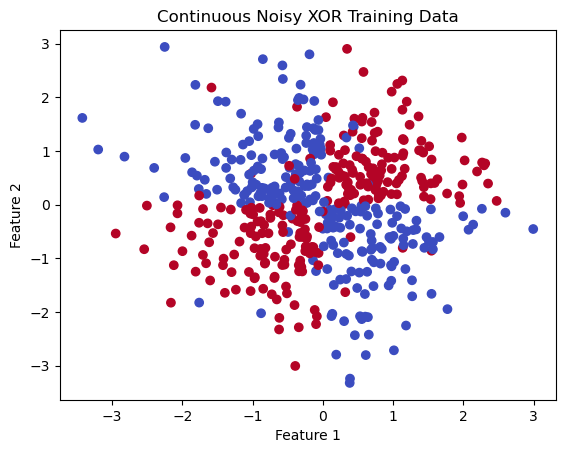

In [6]:
plt.scatter(
    train_dataset.tensors[0][:, 0],
    train_dataset.tensors[0][:, 1],
    c=train_dataset.tensors[1],
    cmap="coolwarm",
)
plt.title("Continuous Noisy XOR Training Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Some boilerplate code

We define some hyperparameters...

In [7]:
TRAIN_BS: int = 32
TEST_BS: int = 1024

EPOCHS: int = 35

... the `DataLoader`s we will use...

In [8]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False)

... and some auxiliary functions.

In [9]:
def compute_accuracy(model: th.nn.Module, dataloader: DataLoader) -> float:
    _ = model.eval()
    with th.no_grad():
        correct: int = 0
        total: int = 0
        for x, y in dataloader:
            total += y.size(0)
            yhat: th.Tensor = model(x)
            correct += (th.round(yhat) == y).sum().item()
        return correct / total

In [10]:
def param_lp_norm(model: th.nn.Module, p: Union[int, float]) -> th.Tensor:
    return th.norm(th.cat([p.flatten() for p in model.parameters()]), p=p)

In [11]:
def train_model(
    model: th.nn.Module,
    loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor],
    optimizer: th.optim.Optimizer,
    trainloader: DataLoader,
    testloader: DataLoader,
    epochs: int,
    trace_norms: bool = False,
) -> Tuple[List[float], List[float], List[float], List[float]]:
    train_accs: List[float] = []
    test_accs: List[float] = []
    l1_norms: List[float] = []
    l2_norms: List[float] = []
    model.eval()
    with th.no_grad():
        train_accs.append(compute_accuracy(model, testloader))
        test_accs.append(compute_accuracy(model, testloader))
        if trace_norms:
            l1_norms.append(param_lp_norm(model, 1).item())
            l2_norms.append(param_lp_norm(model, 2).item())
    model.train()
    for _ in trange(epochs):
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat: th.Tensor = model(x)
            loss: th.Tensor = loss_fx(yhat, y)
            loss.backward()
            optimizer.step()
        with th.no_grad():
            train_accs.append(compute_accuracy(model, trainloader))
            test_accs.append(compute_accuracy(model, testloader))
            if trace_norms:
                l1_norms.append(param_lp_norm(model, 1).item())
                l2_norms.append(param_lp_norm(model, 2).item())
    return train_accs, test_accs, l1_norms, l2_norms

In [12]:
def make_plots(
    train_accs: List[float],
    test_accs: List[float],
    l1_norms: List[float],
    l2_norms: List[float],
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(train_accs, label="Train")
    axs[0].plot(test_accs, label="Test")
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[1].plot(l1_norms, label="L1")
    axs[1].plot(l2_norms, label="L2")
    axs[1].set_title("Parameter Norms")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Norm")
    axs[1].legend()
    plt.show()

In case we will need to add some confounders to our input, here we have a layer just to do that! We will use it later...

In [13]:
class AddNoisyComponents(th.nn.Module):
    def __init__(
        self, n_components: int, placement: str = "last", scale: Union[int, float] = 1
    ):
        super().__init__()
        if placement not in ["last", "first"]:
            raise ValueError("Invalid placement value: should be 'first' or 'last'.")
        self.n_components: int = n_components
        self.placement: str = placement
        self.scale: Union[int, float] = scale

    def forward(self, x: th.Tensor) -> th.Tensor:
        if self.placement == "last":
            return th.cat(
                [x] + [th.randn(x.shape[0], self.n_components) * self.scale], dim=-1
            )
        else:
            return th.cat([th.randn(self.n_components) * self.scale] + [x], dim=-1)

## Our model(s)

And we also define the model for today (or, more precisely: many of them!). As a default, we will use a simple feedforward fully-connected neural network with two hidden layers, ReLU activations, and a sigmoid output layer.

In [14]:
def make_example_classifier(
    in_size: int = 2,
    out_size: int = 1,
    do: Union[int, float] = 0,
    bn: bool = False,
    ln: bool = False,
    linear: bool = False,
) -> th.nn.Module:

    if (bn and ln) or (bn and do) or (ln and do):
        raise ValueError(
            "You should not use both BatchNorm/LayerNorm, or Dropout/Normalization at the same time!"
        )

    hidden_size: int = in_size * out_size * 2
    return th.nn.Sequential(
        # Block #1
        th.nn.Linear(in_size, hidden_size, bias=bn),
        th.nn.ReLU() if not linear else th.nn.Identity(),
        th.nn.Dropout(do) if do > 0 else th.nn.Identity(),
        (
            th.nn.BatchNorm1d(hidden_size, affine=True)
            if bn
            else th.nn.LayerNorm(hidden_size) if ln else th.nn.Identity()
        ),
        # Block #2
        th.nn.Linear(hidden_size, hidden_size, bias=bn),
        th.nn.ReLU() if not linear else th.nn.Identity(),
        th.nn.Dropout(do) if do > 0 else th.nn.Identity(),
        (
            th.nn.BatchNorm1d(hidden_size, affine=True)
            if bn
            else th.nn.LayerNorm(hidden_size) if ln else th.nn.Identity()
        ),
        # Block #3
        th.nn.Linear(hidden_size, out_size),
        th.nn.Sigmoid() if out_size == 1 else th.nn.Softmax(dim=-1),
    )

**Remark**
Mind the order of the layers! In the case of `BatchNorm` and `LayerNorm`, they have been historically placed before the activation function. However, it has been empirically shown that placing normalization layers **after** the activation function can lead to better results. Additionally: if we use the **affine** version (the proper one!) of `BatchNorm`, we can spare some parameters by not using a bias term in the previous layer.

In the case of `Dropout`, it is usually placed after the activation function. If such activation function is a `ReLU`, its placement produces no mathematical difference. However, if we use a different activation function, the placement of `Dropout` can lead to different results.

Finally, you [should not use both **normalization** and **dropout** layers in the same model](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf).

## Let's regularize!

### $\ell_1$ norm regularization (*Lasso*)

We will first discuss $\ell_1$ norm (*Lasso*) regularization. It introduces a penalty term additional to the the loss function that is proportional to the sum of the absolute values of the model parameters. *I.e.:*

$$
\mathcal{L} := L (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_1
$$

where $\vert\vert x \vert\vert_1 = \sum_{j=1}^d \vert x_j \vert$, and the scalar $\lambda \geq 0$ governs the regularization strength.

In the case of $\ell_1$ regularization, Torch does not provide built-in tools to ease its use. To implement it, you would have to either customize the optimizer (definitely not recommended!), create a custom loss function, or tweak the training loop.

In ML, $\ell_1$ regularization is often used as a way to enforce **sparsity** in the model weights: in fact, $l_1$ norm is used as a differentiable proxy for the so-called $l_0$ norm of the weights, defined as the number of nonzero elements of a vector, *i.e.*:

$$\vert\vert x \vert\vert_0 = \sum_{j=1}^d  \delta(x_j \neq 0) $$

For example, recalling the regression example we saw in the beginning, $\ell_1$ regularization would come in handy to sparsify a polynomial model of degree 9 (having 10 parameters) to make it a linear model. We can obtain a similar situation in our *XOR* problem if we add some meaningless features to the data.

In [15]:
LAMBDA_L1: float = 1e-3

l1_overcomplete_model = th.nn.Sequential(
    AddNoisyComponents(10), make_example_classifier(N_FEATURES + 10, 1)
)

l1_optimizer = th.optim.Adam(l1_overcomplete_model.parameters(), lr=1e-3)

loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor] = (
    lambda yhat, y: th.nn.functional.binary_cross_entropy(yhat, y)
    + LAMBDA_L1 * param_lp_norm(l1_overcomplete_model, 1)
)

In [16]:
# Let's print first-layer model parameters, before training
print(f"Before training: \n {l1_overcomplete_model[1][0].weight.data}")

Before training: 
 tensor([[ 0.2249, -0.2060, -0.0636, -0.2114, -0.2510, -0.0108,  0.1993, -0.0534,
         -0.1707,  0.0161, -0.1119,  0.1946],
        [ 0.2075, -0.0796, -0.1217,  0.2251,  0.0093, -0.0253,  0.2806,  0.2835,
          0.2477,  0.2083, -0.2826, -0.1245],
        [-0.2880,  0.0044,  0.0775, -0.1530,  0.0085,  0.2753, -0.1861, -0.0410,
          0.2030,  0.1825, -0.0350,  0.1223],
        [-0.1714,  0.2281, -0.2194, -0.1058, -0.2581,  0.2582, -0.2397,  0.0197,
          0.1839, -0.0391, -0.0574,  0.2695],
        [ 0.2461,  0.2060,  0.1216, -0.0223, -0.1424, -0.1436,  0.0929,  0.0973,
          0.1476,  0.0526,  0.1595,  0.1262],
        [-0.2217, -0.0792, -0.0370,  0.0721, -0.0281, -0.2388,  0.2256,  0.1147,
         -0.1676,  0.1044, -0.1085,  0.1424],
        [-0.1082, -0.1581,  0.1440, -0.2177, -0.0844, -0.0393, -0.2381,  0.0919,
          0.0600,  0.2427, -0.2669, -0.2455],
        [-0.0186, -0.2265,  0.0447,  0.1105,  0.1291,  0.1034, -0.0585, -0.2083,
          0

In [17]:
l1_train_accs, l1_test_accs, l1_l1_norms, l1_l2_norms = train_model(
    l1_overcomplete_model,
    loss_fx,
    l1_optimizer,
    train_loader,
    test_loader,
    EPOCHS,
    trace_norms=True,
)

  0%|          | 0/35 [00:00<?, ?it/s]

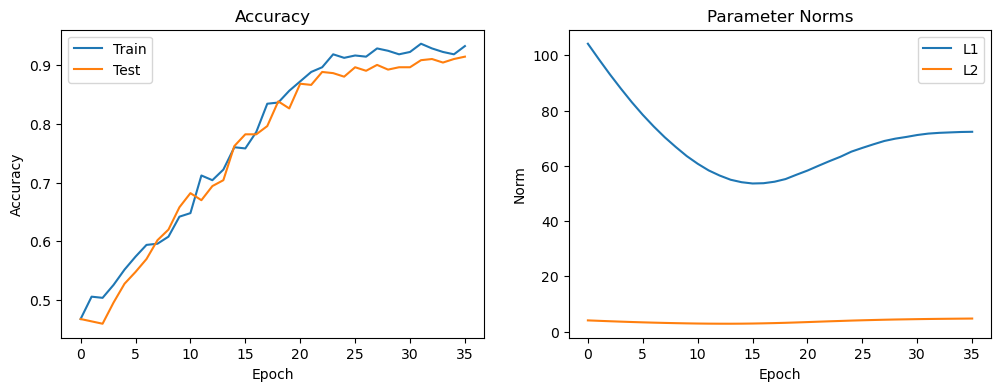

In [18]:
make_plots(l1_train_accs, l1_test_accs, l1_l1_norms, l1_l2_norms)

In [19]:
# Let's print first-layer model parameters, after training
print(f"After training: \n {l1_overcomplete_model[1][0].weight.data}")

After training: 
 tensor([[ 2.0114e-01,  7.3915e-04,  4.1790e-04, -6.8766e-02, -1.8752e-01,
         -1.0712e-03,  1.3080e-01, -6.6784e-05, -6.4881e-02, -1.1783e-03,
         -2.5054e-03,  7.5867e-02],
        [ 7.7590e-02, -2.2977e-04,  4.8691e-04,  4.8400e-03,  6.4152e-04,
          2.3138e-06,  4.1122e-02,  3.5312e-02,  3.9312e-02,  1.7607e-04,
         -9.8629e-02,  2.0214e-04],
        [-4.0284e-01,  3.2622e-01,  2.2602e-03, -1.6462e-02, -1.0929e-02,
          8.6820e-02, -2.6986e-02, -5.6683e-03,  4.2639e-02,  4.6680e-02,
          1.3246e-03, -1.1394e-02],
        [-5.0011e-02,  1.6056e-01,  3.0718e-03, -1.2212e-03, -6.3533e-02,
          4.4780e-05, -1.4566e-02, -2.6189e-06,  1.7040e-03,  4.7194e-04,
         -1.4813e-03,  4.5945e-02],
        [ 5.7714e-01,  5.8566e-01,  1.1720e-02,  6.0599e-03, -5.3343e-04,
         -5.3626e-03,  1.3550e-02,  4.2064e-03,  5.0869e-03,  4.3858e-03,
          4.9806e-03,  2.2969e-02],
        [-5.7149e-01, -4.0773e-01, -7.4986e-03, -7.5651e-04,  

### $\ell_2$ norm regularization (*Ridge*) and *Weight decay*

We will now discuss $\ell_2$ norm (*Ridge*) regularization. It introduces a penalty term additional to the the loss function that is proportional to the sum of the squared values of the model parameters. *I.e.:*

$$
\mathcal{L} := L (\hat{y}, y) + \lambda \cdot \vert\vert \Theta \vert\vert_2^2
$$

where $\vert\vert x \vert\vert_2 = \sqrt{\sum_{j=1}^d x_j^2}$, and the scalar $\lambda \geq 0$ governs the regularization strength.

  0%|          | 0/35 [00:00<?, ?it/s]

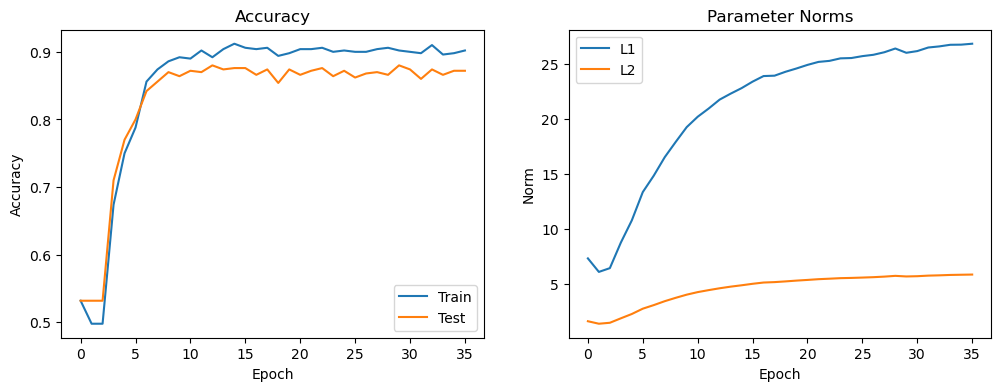

In [20]:
LAMBDA_L2: float = 1e-2

l2_model = make_example_classifier(N_FEATURES, 1)

l2_optimizer = th.optim.Adam(l2_model.parameters(), lr=1e-2)

loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor] = (
    lambda yhat, y: th.nn.functional.binary_cross_entropy(yhat, y)
    + LAMBDA_L2 * param_lp_norm(l2_model, 2)
)

l2_train_accs, l2_test_accs, l2_l1_norms, l2_l2_norms = train_model(
    l2_model, loss_fx, l2_optimizer, train_loader, test_loader, EPOCHS, trace_norms=True
)

make_plots(l2_train_accs, l2_test_accs, l2_l1_norms, l2_l2_norms)

In `PyTorch` (and in Deep Learning in general), $\ell_2$ regularization is often implemented practically as a technique called *weight decay*, where model pareameters are rescaled by a fixed proportion at each optimization step. From the mathematical viewpoint, the two techniques are equivalent only when the learning rate is fixed and the optimization algorithm is (stochastic) gradient descent without momentum. In such case, the role of the `wd` parameter is the same as the $\lambda$ parameter in $\ell_2$ regularization.

  0%|          | 0/35 [00:00<?, ?it/s]

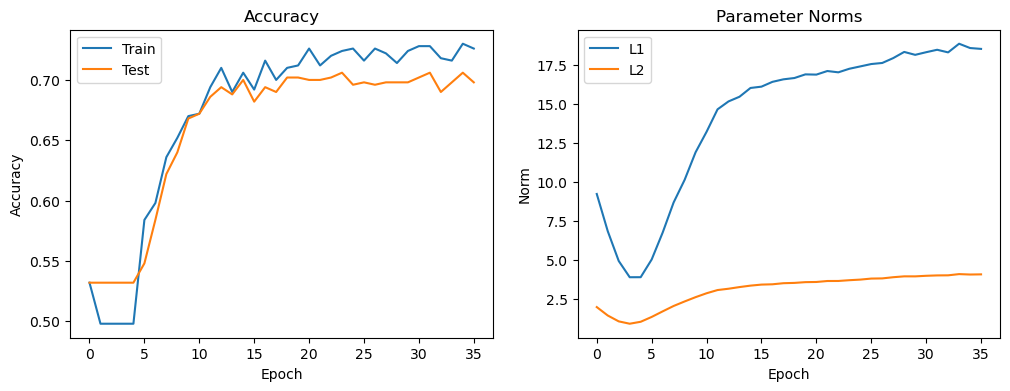

In [21]:
l2_model = make_example_classifier(N_FEATURES, 1)

l2_optimizer = th.optim.Adam(l2_model.parameters(), lr=1e-2, weight_decay=LAMBDA_L2)

loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor] = (
    lambda yhat, y: th.nn.functional.binary_cross_entropy(yhat, y)
)

l2_train_accs, l2_test_accs, l2_l1_norms, l2_l2_norms = train_model(
    l2_model, loss_fx, l2_optimizer, train_loader, test_loader, EPOCHS, trace_norms=True
)

make_plots(l2_train_accs, l2_test_accs, l2_l1_norms, l2_l2_norms)

### *Dropout*

Dropout acts by removing (i.e. *zeroing-out*) a random subset of the neurons in a given layer, differently for each forward pass.

<img src="https://i.ibb.co/PW9rFST/dl2024-regul-dropout.png" width="500"/>

It is governed by one hyperparameter ($p$), which is the fraction of layer neurons to be dropped out.

During training, each time a layer produces an output, a fraction $p$ of such output gets discarded (more precisely, the output of each neuron gets discarded with probability $p$). This process helps training the network in such a way that the co-evolution between neurons gets *discouraged*. To say it in simpler terms, it aims at a trained model where each neuron output is independent from the output of other neurons within the same layer.

At inference time, dropout is turned off, and the model is used as-is. This means that the output of each neuron is multiplied by $1-p$ to keep the expected value of the output constant.

In torch, we find Dropout available as a module, part of `torch.nn`.

**Remark**
Since dropout behaves differently during training and inference, we must be careful in using the `model.train()` and `model.eval()`switches appropriately!

  0%|          | 0/35 [00:00<?, ?it/s]

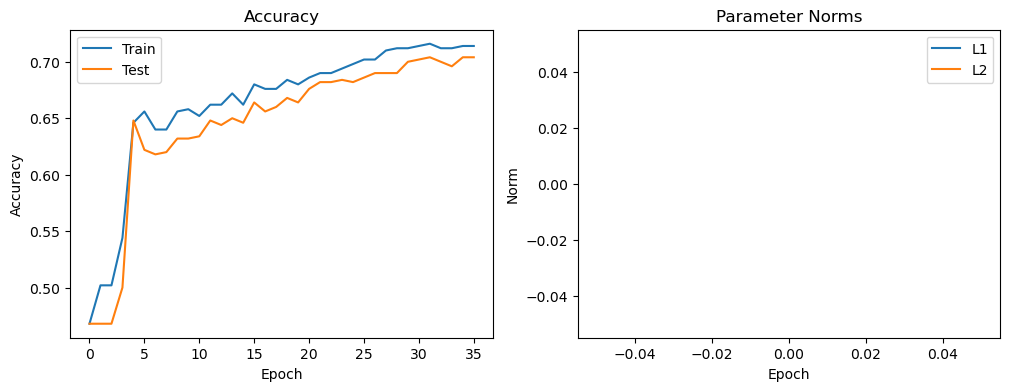

In [22]:
DROPOUT: float = 0.2

dropout_model = make_example_classifier(N_FEATURES, 1, do=DROPOUT)

dropout_optimizer = th.optim.Adam(dropout_model.parameters(), lr=0.5e-2)

loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor] = (
    lambda yhat, y: th.nn.functional.binary_cross_entropy(yhat, y)
)

dropout_train_accs, dropout_test_accs, _, _ = train_model(
    dropout_model, loss_fx, dropout_optimizer, train_loader, test_loader, EPOCHS
)

make_plots(dropout_train_accs, dropout_test_accs, [], [])

### *Early stopping*

Early stopping is yet another example of a regularization technique that relies mostly on practical and experimental observations rather than on a strong supporting mathematical theory.

It is based upon the concept of **validation**, which is the assessment of a model, during training, on unseen data **additionally** to the *test set*. Actually, what insofar we have described as *testing* in Deep Learning is technically, indeed, a validation procedure.

In fact, to be precise:
* a validation dataset may be obtained as result of a random splitting of the original **training** dataset;
* a testing dataset should be obtained instead from a model deployed **in the wild** and should consist of data unseen (from both the model and its architect!) during the model design and training phases.

In a *standard* academic setting it's very hard to obtain a proper testing dataset for methodological novelties. This has produced a slight mixup in the meaning of *testing* and *validation*.

In any case, early stopping requires us to assess the model at each epoch to get a proxy for the testing performance (validation step). That should gives us an idea of how the model **learns to generalize** (if it ever does...) during training.

The *theoretical trend* of machine learning (from the 90s), which is pretty much absent in modern Deep Learning due to an interplay of factors, is the following (*descent and ascent* of the validation curve):

<img src="https://i.ibb.co/Y236zLs/dl2024-regul-classical-Tr-Val.jpg" width="600"/>

The idea of *early stopping* comes from the fact that it is not obvious that **more training epochs means better performances**: there can be a *sweet spot* at which we are not at the minimum of the training loss but we are *optimal* in terms of generalization (on the validation set). Then it is a good idea to interrupt the training and save the model weights for evaluation.

There are many possible criteria to decide when to stop exactly: you can find a complete discussion *e.g.* [here](https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf). The simplest criterion stop training when the generalization loss (i.e. the validation loss) is stable or increasing for a number of consecutive epochs.

As anticipated, modern Deep Learning practice suggests that early stopping is not always a good idea, since the trend in the previous plot is often not visible. Something like this can happen instead, *i.e.* the ([Double Descent Phenomenon](https://openai.com/blog/deep-double-descent/)):

<img src="https://i.ibb.co/2dZv3j7/dl2024-regul-doubledescent.png" width="600"/>

Unfortunately, for the sake of time, we will not implement early stopping in this lab. However, you can try if you want! 🙃


# Normalization techniques

Now, we will move to **normalization** techniques, which are aimed at transforming (input) features of a layer to be on a mutually similar scale. This is ultimately done to improve the performance, convergence rate, and training stability of the model.

We will have a look at [Batch Normalization (BatchNorm)](https://arxiv.org/abs/1502.03167) and [Layer Normalization (LayerNorm)](https://arxiv.org/pdf/1607.06450.pdf). These two techniques follow the same procedure, *i.e.* rescaling data to have $0$ mean and unit variance (plus an **affine** term!), but work on different axes:

<img src="https://i.ibb.co/XjCgRd5/dl2024-regul-batchnorm-vs-layernorm.png" width="500"/>

Choosing between BatchNorm and LayerNorm (or no normalization at all!) is a generally hard task, as there is no fixed rule or heuristic guideline. As a rule of thumb, though, Computer Vision architectures often employ BatchNorm, and NLP ones do use LayerNorm. However, this is highly variable and the situation is changing with the widespread success of Transformer architectures (originally intended for NLP) on different tasks (includinv Vision).

In `PyTorch`, BatchNorm and LayerNorm are implemented as built-in layers, available from the `nn` package.

### *Batch Normalization*

Note: `BatchNorm1d` assumes a 2-D or 3-D input. If you are handling images, which are 4-D (`batch size`, `channels`, `height`, `width`) you can switch to `BatchNorm2d`.

  0%|          | 0/35 [00:00<?, ?it/s]

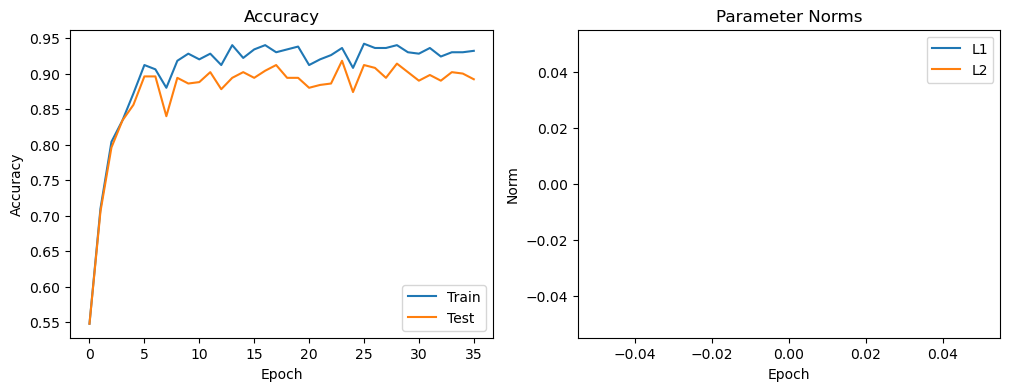

In [23]:
batchnorm_model = make_example_classifier(N_FEATURES, 1, bn=True)

batchnorm_optimizer = th.optim.Adam(batchnorm_model.parameters(), lr=1e-2)

loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor] = (
    lambda yhat, y: th.nn.functional.binary_cross_entropy(yhat, y)
)

batchnorm_train_accs, batchnorm_test_accs, _, _ = train_model(
    batchnorm_model, loss_fx, batchnorm_optimizer, train_loader, test_loader, EPOCHS
)

make_plots(batchnorm_train_accs, batchnorm_test_accs, [], [])

### *Layer Normalization*

LayerNorm works in a very similar way as BatchNorm, and it accepts as input the shape of the slice on which you want to compute mean and standard deviation: for an image it would be something like `normalized_shape=[C,H,W]`.

**Remark**
Unlike Batch Normalization, which applies scalar *scale* and *bias* for each entire channel with the `affine` option, Layer Normalization applies per-element *scale* and *bias* with `elementwise_affine`.

  0%|          | 0/35 [00:00<?, ?it/s]

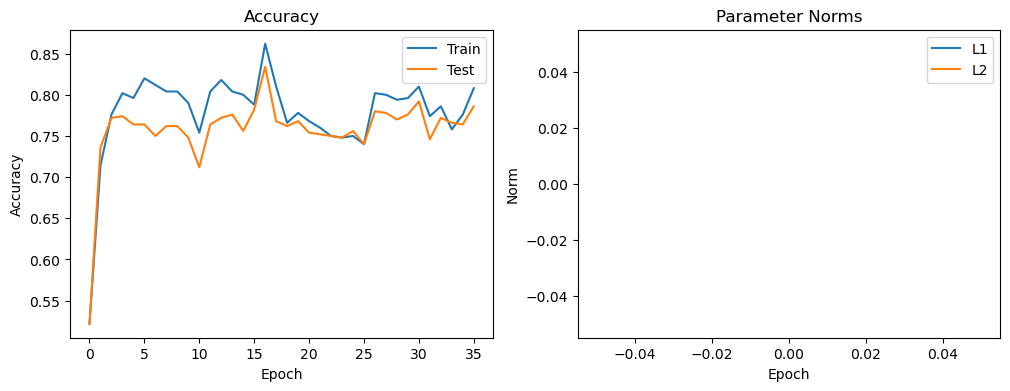

In [24]:
layernorm_model = make_example_classifier(N_FEATURES, 1, ln=True)

layernorm_optimizer = th.optim.Adam(layernorm_model.parameters(), lr=1e-2)

loss_fx: Callable[[th.Tensor, th.Tensor], th.Tensor] = (
    lambda yhat, y: th.nn.functional.binary_cross_entropy(yhat, y)
)

layernorm_train_accs, layernorm_test_accs, _, _ = train_model(
    layernorm_model, loss_fx, layernorm_optimizer, train_loader, test_loader, EPOCHS
)

make_plots(layernorm_train_accs, layernorm_test_accs, [], [])